Event Study: Cybersecurity Breaches Effects on Stock Price

<b>include a blurb here talking about our study. talk about why we pay attention to date of disclosure</b>

In [4]:
# Standard libraries
import pandas as pd
import numpy as np
from scipy import stats
# Visualization
import matplotlib.pyplot as plt
import datetime
import os 

# os.system("pip install wrds") # TODO: Probably put this in utils.py
import wrds
# os.system("pip install pandas-datareader")
import pandas_datareader.data as web

# os.system("pip install seaborn")
import seaborn as sns
pd.set_option('display.max_columns', None)
from sklearn.linear_model import LinearRegression

# Note we don't actually need pandas_datareader. Could import/use YahooFinanceAPI which gives same info

<h2>Data Collection</h2> 

We will be using the <a href= "https://wrds-www.wharton.upenn.edu/">WRDS</a> (Wharton Research Data Services) database to find financial analyst predictions on stock price using their <a href= "https://www.investopedia.com/terms/i/ibes.asp">IBES</a> dataset. The WRDS database is provided to all UMD staff and students for free, you can sign up for an account <a href="https://wrds-www.wharton.upenn.edu/register/">here</a>. When running this following section of code, you must supply your account's credentials. We recommend setting up a <a href = "https://matteocourthoud.github.io/post/wrds/"> pgpass</a> to help automate the process.

In [2]:
db = wrds.Connection()

Enter your WRDS username [gabri]:gnaval
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


We will be using the Audit Analytics February 2021 issue of cybersecurity databreaches. To get this dataset, we contacted the University of Maryland's Smith Business School, which provided this Excel file to us. <a href = "https://www.auditanalytics.com/">Audit Analytics</a> is an organization that tracks relevant business and financial data such as the information of a company cybersecurity breach. 

We will now load in the data by accessing the correct Excel sheet. 

In [3]:
# Audit Analytics Dataset
xls = pd.ExcelFile('../data/audit_analytics.xlsx')
aa_records_df = pd.read_excel(xls, 'PublicCyber')

Each row in this dataset represents a company's cybersecurity breach. The dataset contains useful information such as the company breached, date of public disclosure of the breach, and other varying information about the company and the type of cybersecurity breach performed. 

To clean the data, we need to drop all the rows that don't contain any company tickers. <a href ="https://www.wikiwand.com/en/Ticker_symbol">Tickers</a>, consisting of numbers and letters, are short abbreviations uniquely identifying a publicly traded company (Ex: Amazon is uniquely identified by their ticker, AMZN). If a row doesn't have a ticker symbol, then there may have been data corruption, human errors logging the data, or the company may not be publicly traded. Either way, we need to remove the rows. We also extract the relevant columns for our analysis (as shown in the table_columns array). Once this is all done, it leaves us with a dataset of 737 cybersecurity breaches on publicly traded companies.

In [ ]:
# Data Cleaning
aa_records_df = aa_records_df[aa_records_df['Ticker'].isna() != True].reset_index(drop=True)
table_columns = ['Company name', 'Ticker', 'Date of Breach', 'Date Became Aware of Breach', 'Date of Disclosure',
                 'Number of Records', 'Type of Info', 'Information', 'Attack', 'Region', 'SIC Code']
aa_records_df = aa_records_df[aa_records_df.columns.intersection(table_columns)]

Now, let's try to find the monthly stock price of each of these firms following the disclosure of the breach.

Before we do that, we define a short helper function that will help us find the closest date in a set that corresponds to X months after the disclosure of a breach. We will make use of this utility in our main function for finding monthly stock prices.

In [ ]:
def nearest(items, pivot):
    """
    Gets closest day in a set (used to obtain stock price X months after disclosure)
    """
    return min(items, key=lambda x: abs((x - pivot).days))

With that out of the way, let's construct a function to obtain the monthly stock prices after the disclosure of the data breach. Let's break it down! 

Our function has two parameters: a row from our original breach dataframe and the number of months to get stock prices from. First, our function determines the range of dates to obtain monthly stock prices. Please note that our starting date is a day before the disclosure breach as to control for any fluctuations in stock price due to that disclosure. Following this, we leverage <a href="https://pandas-datareader.readthedocs.io/en/latest/index.html">pandas_datareader</a>, an <a href="https://rapidapi.com/blog/api-glossary/api-wrapper/#:~:text=In%20that%20line%2C%20an%20API,to%20automate%20API%2Dreliant%20processes.">API wrapper</a> for various API's. Specifically, we will be using its <a href = "https://finance.yahoo.com/">YahooFinance</a> API functionality, which will provide us with a dataframe of stock prices (df) beginning at our start date and ending at our end date. We then traverse through this dataframe, using our nearest helper function, to obtain the monthly stock prices and return them as an array. 

If the YahooFinance API cannot find a company's stock price for whatever reason, it returns an array of np.nan's. Likewise, if 
no stock price is available for a month because it's missing or because that month's date lies in the future and hasn't occurred yet, then the array will be populated by np.nan's for those months.

Note: We record the <a href = "https://finance.zacks.com/significance-closing-price-stock-3007.html">closing</a> stock prices, meaning its the stock price at the end of a day. <br>
Note: The YahooFinance API has a limit of 2,000 requests per hour. As we only have 737 breaches, we won't be hitting that limit, but keep that in mind when using API's.

In [5]:
today = datetime.datetime.today().date()

def stock_after_disclosure(row, num_months):
    """
    Returns an array containing the monthly stock price of a firm after date of disclosure (0 - num_months months after breach).
    If firm exists in YahooFinance database, but no stock price available for a month (either b/c that date has yet to occur 
    or b/c simply N/A),
    returns np.nan.
    If firm does not exist in YahooFinance database, return array of np.nan's.
    
    Parameters: 
    row : Dataframe row
        Input dataframe's row (used along with df.apply)
    num_months : int
        Month limit
    """
    start = pd.to_datetime(row['Date of Disclosure']) 
    end = start + pd.DateOffset(months = num_months)
    start -= datetime.timedelta(days=1) 
    try:
        df = web.DataReader(row['Ticker'], 'yahoo', start, end)
        lst = []
        for month in range(0, num_months + 1):
            if today <= (start + pd.DateOffset(months = month)).date():
                for x in range(month, num_months + 1):
                    lst.append(np.nan)
                break
            date = nearest(df.index, (start + pd.DateOffset(months = month)))
            lst.append(df.loc[date]["Close"])
        return lst
    except Exception as e:
        print("Error at %s" % row['Ticker'])
        print(repr(e))
        return [np.nan] * (num_months + 1)

Let's run our function on each row in our dataset. We'll be finding the monthly stock prices spanning a year after the disclosure of the breach. 

Note: This section of code takes a while to run (20-30 minutes) because we will be making API requests, loading in data from a server, and performing operations on said data.

In [ ]:
lst = []
months_after = 12 #Toggle this value
col = []
# Set the column names for new dataframe
for i in range(0, months_after + 1):
    col.append("Stock Price (%s months DoD)" % i)

# Create array of arrays that contains stock prices after date of disclosure for each breach
for index, row in aa_records_df.iterrows():
    x = stock_after_disclosure(row, months_after)
    lst.append(x)

Following this, we can concatenate said data to our original dataframe.

In [ ]:
# Merge stock price after breach with original dataframe
stock_prices = pd.DataFrame(lst, columns = col)
stock_price_aa_records = pd.concat([aa_records_df, stock_prices], axis=1, join='inner')

We now have the actual stock prices. Let's move on to finding analyst predictions for these companies. 

We define the function below to find the analyst stock price predictions. It makes use of the <a href="https://www.investopedia.com/terms/i/ibes.asp">IBES</a> database in WRDS. The function takes all the financial analyst predictions within a month of the disclosure of the breach that forecast the company's stock price a year into the future. Since multiple financial analysts may make predictions, this function returns the median and mean of these predictions. If no predictions are found, the function returns np.nan's. 

Note: This function makes use of SQL, a programming language used to communicate with databases. Here are some helpful resources to get started learning about SQL: <a href = "https://www.codecademy.com/learn/learn-sql">CodeAcademy</a>, <a href = "https://www.khanacademy.org/computing/computer-programming/sql">KhanAcademy</a>

In [15]:
def analyst_stock_price(row):
    """
    Returns the median and mean of analyst stock price forecasts for a firm, where the forecasts are within a month after the beach. 
    These forecasts predict the stock price 12 months into the future.
    
    Parameters
        row - Dataframe row
        Input dataframe's row (used along with df.apply)
    Returns
        List of length 2. [median, mean]
    """
    date = pd.to_datetime(row['Date of Disclosure'])
    
    sql_query="""
    SELECT VALUE as stock_price
    FROM ibes.ptgdet
    WHERE OFTIC ='{}' AND CAST(HORIZON as int) = 12 AND ANNDATS BETWEEN '{}' and '{}'
    """.format(row['Ticker'], date, date + pd.DateOffset(months = 1))
    
    df = db.raw_sql(sql_query)
    
    if len(df.index) == 0:
        return [np.nan] * 2
    return [df['stock_price'].median(), df['stock_price'].mean()]
    

We can now run the function on each company to get the financial analyst forecasts.

In [ ]:
# Create array of arrays that contains stock prices after date of disclosure for each breach
lst = []
for index, row in stock_price_aa_records.iterrows():
    lst.append(analyst_stock_price(row))
    
# Merge stock price after breach with original dataframe
median_mean_df = pd.DataFrame(lst, columns = ['median stock forecast', 'mean stock forecast'])
stock_price_aa_records = pd.concat([stock_price_aa_records, median_mean_df], axis=1, join='inner')

Nice! We have now collected all the data to compare actual stock prices with financial analyst predicted stock prices. But before we do some Exploratory Data Analysis (EDA), we need to do...

<h2>Data Transformation and Management</h2> 

As it turns out, we might want to transform some of our data relating to stock prices because of innate variation between companies. 

To better understand this problem, consider this hypothetical: Suppose company A's and company B's stock price both double after a year. However, company A's initial stock was much smaller, say it started at \\$10 and became \\$20 per share, while company B's stock went from \\$100 to \\$200 per share. Their numerical growth are rather different, but their percent growth are the same. When comparing growth between companies, it makes more sense to compare percent growth since it will better control for the already established stock of that company (whether that be high or low). In a way, finding the percent growth is like standardizing each company's current stock price by their initial stock price.

For that reason, we need to be looking at percent stock price change for these companies, where the initial stock price corresponds to the stock price the day of the disclosure for the breach. The code below transforms the data to percent stock price change for the actual and predicted stock prices.

In [8]:
stock_prices = pd.DataFrame()
n = 1 
for x in col[1:]:
    stock_prices[n] = stock_price_aa_records.apply(lambda row: (row[x] - row[col[0]])/row[col[0]], axis = 1)
    n += 1
    
t1 = stock_price_aa_records.apply(lambda row: (row['median stock forecast']-row['Stock Price (0 months DoD)'])/row['Stock Price (0 months DoD)'], axis=1)
t2 = stock_price_aa_records.apply(lambda row: (row['mean stock forecast']-row['Stock Price (0 months DoD)'])/row['Stock Price (0 months DoD)'], axis=1)

analysts_percent = pd.concat([stock_prices[12], pd.DataFrame(t1), pd.DataFrame(t2)], axis=1, join='inner')

<h2>Exploratory Data Analysis</h2>

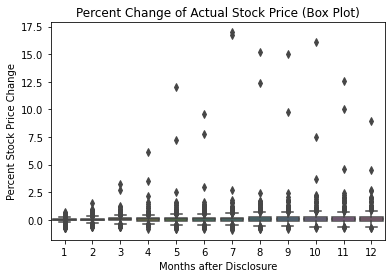

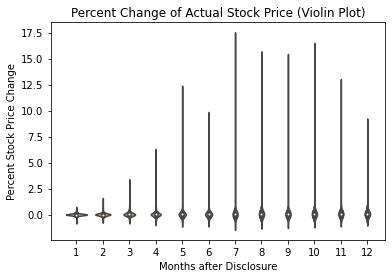

In [10]:
boxplot = sns.boxplot(x="variable", y = "value", data=pd.melt(stock_prices).dropna())
boxplot.set(xlabel="Months after Disclosure", ylabel='Percent Stock Price Change') 
boxplot.set_title("Percent Change of Actual Stock Price (Box Plot)")
plt.show()

ax = sns.violinplot(x='variable', y='value', data=pd.melt(stock_prices).dropna())

plt.xlabel('Months after Disclosure')
plt.ylabel('Percent Stock Price Change')
ax.set_title("Percent Change of Actual Stock Price (Violin Plot)")
ax.plot()
plt.show()

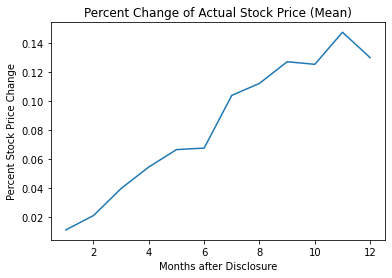

In [64]:
# It appears that, on average, stock price goes up
plt.plot(np.arange(1, 13), stock_prices.mean())
plt.xlabel('Months after Disclosure')
plt.ylabel('Percent Stock Price Change')
plt.title("Percent Change of Actual Stock Price (Mean)")
plt.show()

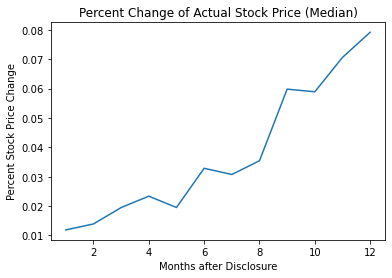

In [26]:
# Let's use median because there are some outliers. Same trend seems to occur
plt.plot(np.arange(1, 13), stock_prices.median())
plt.xlabel('Months after Disclosure')
plt.ylabel('Percent Stock Price Change')
plt.title("Percent Change of Actual Stock Price (Median)")
plt.show()

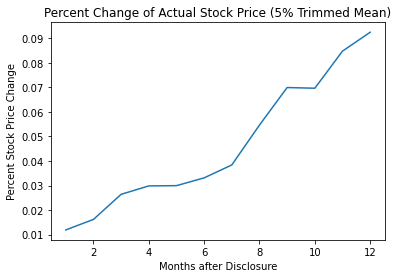

In [9]:
# Let's take 5% trimmed mean (get rid of some outliers)
trimmed_means = []
for x in range(1, months_after + 1):
    trimmed_means.append(stats.trim_mean(stock_prices[x].dropna(), 0.05))
plt.plot(np.arange(1, 13), trimmed_means)
plt.xlabel('Months after Disclosure')
plt.ylabel('Percent Stock Price Change')
plt.title("Percent Change of Actual Stock Price (5% Trimmed Mean)")
plt.show()    

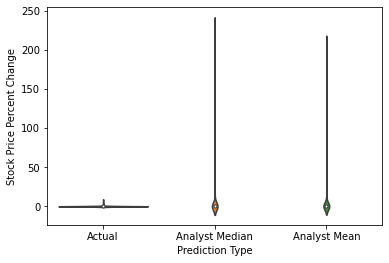

In [68]:
violinplot = sns.violinplot(x="variable", y = "value", data=pd.melt(analysts_percent[['Actual', 'Analyst Median', 'Analyst Mean']]).dropna())
violinplot.set(xlabel="Prediction Type", ylabel='Stock Price Percent Change') # Where x month is percent change from start of breach
plt.show()

In [73]:
z_scores = stats.zscore(analysts_percent['Analyst Median'].dropna())

abs_z_scores = np.abs(z_scores)
medians_no_outliers = analysts_percent['Analyst Median'].dropna()[abs_z_scores < 3]

In [72]:
z_scores = stats.zscore(analysts_percent['Analyst Mean'].dropna())

abs_z_scores = np.abs(z_scores)
means_no_outliers = analysts_percent['Analyst Mean'].dropna()[abs_z_scores < 3]

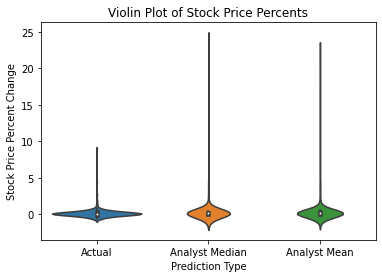

In [76]:
violinplot = sns.violinplot(x="variable", y = "value", data=pd.melt(pd.concat([analysts_percent['Actual'],medians_no_outliers, means_no_outliers], axis=1)))
violinplot.set(xlabel="Prediction Type", ylabel='Stock Price Percent Change') # Where x month is percent change from start of breach
violinplot.set_title("Violin Plot of Stock Price Percents")
plt.show()

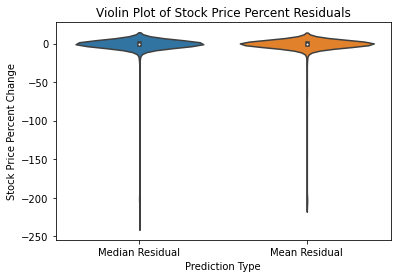

In [19]:
analysts_percent['Median Residual'] = analysts_percent.apply(lambda row: row['Actual'] - row["Analyst Median"], axis =1)
analysts_percent['Mean Residual'] = analysts_percent.apply(lambda row: row['Actual'] - row["Analyst Mean"], axis =1)

violinplot = sns.violinplot(x="variable", y = "value", data=pd.melt(analysts_percent[['Median Residual', 'Mean Residual']]))
violinplot.set(xlabel="Prediction Type", ylabel='Stock Price Percent Change') # Where x month is percent change from start of breach
violinplot.set_title("Violin Plot of Stock Price Percent Residuals")
plt.show()

In [128]:
print(analysts_percent['Median Residual'].describe())
print()
print(analysts_percent['Mean Residual'].describe())

count    474.000000
mean      -1.770291
std       17.214635
min     -231.820000
25%       -0.278764
50%       -0.035162
75%        0.182663
max        4.721649
Name: Median Residual, dtype: float64

count    474.000000
mean      -1.714790
std       16.531061
min     -208.660000
25%       -0.286937
50%       -0.030198
75%        0.193663
max        4.721649
Name: Mean Residual, dtype: float64


Residual = Actual - Predicted
It looks like they tend to overshoot. TODO: Maybe perform hypothesis test here?

In [169]:
stats.ttest_1samp(a=analysts_percent['Median Residual'].dropna(), popmean=0).pvalue/2

0.012813095635420874

In [172]:
stats.ttest_1samp(analysts_percent['Mean Residual'].dropna(), popmean=0).pvalue/2

0.01218801191734196

In [56]:
z_scores = stats.zscore(analysts_percent['Median Residual'].dropna())

abs_z_scores = np.abs(z_scores)
no_outliers_median = analysts_percent['Median Residual'].dropna()[abs_z_scores < 3]


In [57]:
z_scores = stats.zscore(analysts_percent['Mean Residual'].dropna())

abs_z_scores = np.abs(z_scores)
no_outliers_mean = analysts_percent['Mean Residual'].dropna()[abs_z_scores < 3]


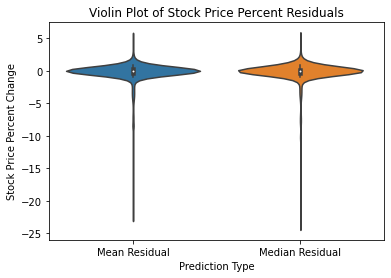

In [58]:
violinplot = sns.violinplot(x="variable", y = "value", data=pd.melt(pd.concat([no_outliers_mean, no_outliers_median], axis=1)))
violinplot.set(xlabel="Prediction Type", ylabel='Stock Price Percent Change') # Where x month is percent change from start of breach
violinplot.set_title("Violin Plot of Stock Price Percent Residuals")
plt.show()

In [59]:
stats.ttest_1samp(a=no_outliers_median, popmean=0).pvalue/2

0.0011165811457134014

In [60]:
stats.ttest_1samp(a=no_outliers_mean, popmean=0).pvalue/2

0.00045330492452277753